In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import optuna
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import statsmodels.api as sm

c:\Users\Alexandre\anaconda3\envs\tf10\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_18748\82198243.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def merge_dfs(list_df):
    df = list_df[0]

    for i in range(1, len(list_df)):
        df = pd.merge(df, list_df[i], how='outer', on='date')

    df = df.fillna(df.mean())

    return df.sort_values(by='date').reset_index(drop=True)

In [3]:
cnt_join = pd.read_csv("series/count_join.csv")
max_hate = pd.read_csv("series/max_hate.csv")
sum_hate = pd.read_csv("series/sum_hate.csv")
avg_hate = pd.read_csv("series/avg_hate.csv")
max_news = pd.read_csv("series/max_news.csv")
sum_news = pd.read_csv("series/sum_news.csv")
avg_news = pd.read_csv("series/avg_news.csv")
cnt_news = pd.read_csv("series/cnt_news.csv")
per25_hate = pd.read_csv("series/per25_hate.csv")
per75_hate = pd.read_csv("series/per75_hate.csv")
per90_hate = pd.read_csv("series/per90_hate.csv")
per99_hate = pd.read_csv("series/per99_hate.csv")

In [4]:
merge_df = merge_dfs([cnt_join[['date', 'rate']], max_hate, sum_hate, avg_hate, max_news, sum_news, avg_news, cnt_news, per25_hate, per75_hate, per90_hate, per99_hate])
merge_df['date'] = pd.to_datetime(merge_df['date'])

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_18748\1584734230.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'per_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = pd.merge(df, list_df[i], how='outer', on='date')
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_18748\1584734230.py:7: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


In [5]:
merge_df['day_of_week'] = merge_df['date'].dt.dayofweek
merge_df['day_of_month'] = merge_df['date'].dt.day
merge_df['month'] = merge_df['date'].dt.month
merge_df['day_of_year'] = merge_df['date'].dt.dayofyear
merge_df['week_of_year'] = merge_df['date'].dt.weekofyear
merge_df['quarter'] = merge_df['date'].dt.quarter

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_18748\188536859.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merge_df['week_of_year'] = merge_df['date'].dt.weekofyear


In [6]:
merge_df['day_of_week_sin'] = np.sin(merge_df['day_of_week']*(2.*np.pi/7))
merge_df['day_of_week_cos'] = np.cos(merge_df['day_of_week']*(2.*np.pi/7))
merge_df['day_of_month_sin'] = np.sin(merge_df['day_of_month']*(2.*np.pi/30))
merge_df['day_of_month_cos'] = np.cos(merge_df['day_of_month']*(2.*np.pi/30))
merge_df['month_sin'] = np.sin((merge_df['month']-1)*(2.*np.pi/12))
merge_df['month_cos'] = np.cos((merge_df['month']-1)*(2.*np.pi/12))
merge_df['day_of_year_sin'] = np.sin(merge_df['day_of_year']*(2.*np.pi/365))
merge_df['day_of_year_cos'] = np.cos(merge_df['day_of_year']*(2.*np.pi/365))
merge_df['week_of_year_sin'] = np.sin(merge_df['week_of_year']*(2.*np.pi/52))
merge_df['week_of_year_cos'] = np.cos(merge_df['week_of_year']*(2.*np.pi/52))
merge_df['quarter_sin'] = np.sin((merge_df['quarter']-1)*(2.*np.pi/4))
merge_df['quarter_cos'] = np.cos((merge_df['quarter']-1)*(2.*np.pi/4))

In [7]:
merge_df.drop(['date'], axis=1, inplace=True)
merge_df

,rate,max_x,sum_x,avg_x,max_y,sum_y,avg_y,cnt,per_x,per_y,...,day_of_month_sin,day_of_month_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos
0,28.485294,0.9907,92.8908,0.047956,458,799,266.333333,3,0.0003,0.008400,...,0.207912,0.978148,0.0,1.000000e+00,0.017213,0.999852,-2.449294e-16,1.000000,0.0,1.000000e+00
1,23.651163,0.9950,51.2714,0.050414,589,1644,234.857143,7,0.0003,0.008300,...,0.406737,0.913545,0.0,1.000000e+00,0.034422,0.999407,-2.449294e-16,1.000000,0.0,1.000000e+00
2,27.139241,0.9959,99.9323,0.046610,257,1099,137.375000,8,0.0003,0.007400,...,0.587785,0.809017,0.0,1.000000e+00,0.051620,0.998667,1.205367e-01,0.992709,0.0,1.000000e+00
3,35.594595,0.9975,49.3796,0.037494,282,887,98.555556,9,0.0002,0.005000,...,0.743145,0.669131,0.0,1.000000e+00,0.068802,0.997630,1.205367e-01,0.992709,0.0,1.000000e+00
4,29.492308,0.9928,81.8804,0.042713,143,769,69.909091,11,0.0002,0.007700,...,0.866025,0.500000,0.0,1.000000e+00,0.085965,0.996298,1.205367e-01,0.992709,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,12.064171,0.9989,210.0204,0.093094,453,1223,61.150000,20,0.0004,0.026925,...,-0.866025,0.500000,1.0,6.123234e-17,0.917584,-0.397543,8.854560e-01,-0.464723,1.0,6.123234e-17
480,15.239726,0.9989,177.5287,0.079788,789,3455,98.714286,35,0.0004,0.023700,...,-0.743145,0.669131,1.0,6.123234e-17,0.910605,-0.413279,8.854560e-01,-0.464723,1.0,6.123234e-17
481,15.489655,0.9984,169.6245,0.075523,485,3382,86.717949,39,0.0004,0.020975,...,-0.587785,0.809017,1.0,6.123234e-17,0.903356,-0.428892,8.854560e-01,-0.464723,1.0,6.123234e-17
482,11.074627,0.9988,222.3370,0.099882,521,2535,74.558824,34,0.0004,0.028800,...,-0.406737,0.913545,1.0,6.123234e-17,0.895839,-0.444378,8.854560e-01,-0.464723,1.0,6.123234e-17


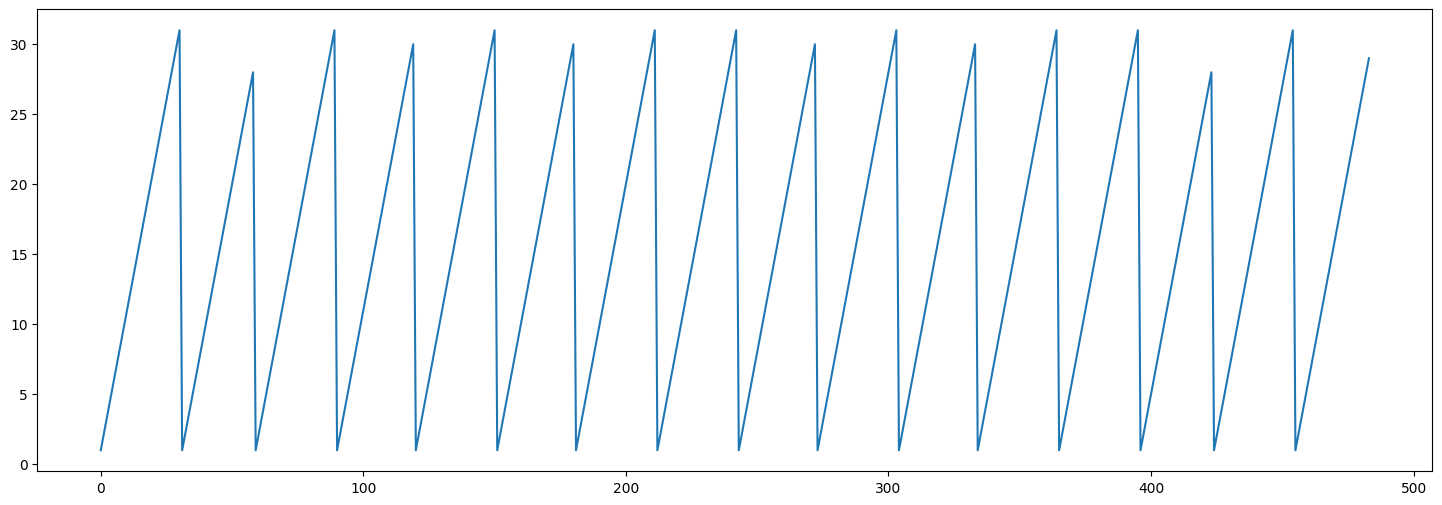

In [121]:
plt.figure(figsize=(18, 6))
plt.plot(merge_df['day_of_month'])
plt.show()

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [186]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go


# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merge_df)

# Define sequence length and forecasting horizon
sequence_length = 5
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets
# split_ratio = 0.8
# split_index = int(split_ratio * len(X))
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

split_train = 0.6
split_val = 0.8
split_index_train = int(split_train * len(X))
split_index_val = int(split_val * len(X))
X_train, X_val, X_test = X[:split_index_train], X[split_index_train:split_index_val], X[split_index_val:]
y_train, y_val, y_test = y[:split_index_train], y[split_index_train:split_index_val], y[split_index_val:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(Dense(y_train.shape[2]))  # Output layer with one neuron per variable
# Compile the model
model.compile(optimizer='nadam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=2, verbose=1, validation_data=(X_val, y_val))

# Make predictions on the test data
predictions = model.predict(X_val)

# Inverse transform the scaled predictions and actual values
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_train.shape[2]))
actual_values = scaler.inverse_transform(y_val.reshape(-1, y_train.shape[2]))

# Calculate RMSE for each variable
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))


Epoch 1/10
144/144 [==============================] - 3s 8ms/step - loss: 0.1317 - val_loss: 0.0981
Epoch 2/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0853 - val_loss: 0.0944
Epoch 3/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0762 - val_loss: 0.0865
Epoch 4/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0703 - val_loss: 0.0837
Epoch 5/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0686 - val_loss: 0.0844
Epoch 6/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0673 - val_loss: 0.0767
Epoch 7/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0665 - val_loss: 0.0830
Epoch 8/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0641 - val_loss: 0.0689
Epoch 9/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0627 - val_loss: 0.0770
Epoch 10/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0610 - val_loss: 0.0692

In [8]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Define a simple multivariate LSTM model using Keras
def create_model(input_dim, hidden_dim, num_layers, dropout_sug):
    model = keras.Sequential()
    for _ in range(num_layers):
        model.add(LSTM(hidden_dim, return_sequences=True))
    model.add(LSTM(hidden_dim))
    model.add(Dropout(dropout_sug))
    model.add(Dense(1))
    return model

# Hyperparameter optimization objective function
def objective(trial):
    # Define hyperparameters to optimize
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    num_layers = trial.suggest_int('num_layers', 0, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_sug = trial.suggest_float('dropout_sug', 0.0, 0.5)
    batch_sug = trial.suggest_categorical('batch_sug', [1, 4, 8, 16])
    sequence_sug = trial.suggest_int('sequencce_sug', 3, 30)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(merge_df)

    # Define sequence length and forecasting horizon
    sequence_length = sequence_sug
    forecast_horizon = 1

    # Create input-output pairs
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
        X.append(scaled_data[i:i+sequence_length])
        y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

    X, y = np.array(X), np.array(y)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    
    # Create the Keras model
    model = create_model(input_dim=5, hidden_dim=hidden_dim, num_layers=num_layers, dropout_sug=dropout_sug)
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    
    # Training loop
    history = model.fit(X_train, y_train, epochs=30, batch_size=batch_sug, validation_data=(X_val, y_val), verbose=0)
    
    # Get the final validation loss
    val_loss = history.history['val_loss'][-1]
    
    return val_loss

sampler = optuna.samplers.TPESampler(seed=42)

# Create an Optuna study and optimize
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and value
best_params = study.best_params
best_value = study.best_value
print("Best hyperparameters:", best_params)
print("Best validation loss:", best_value)


[I 2023-10-22 19:20:07,910] A new study created in memory with name: no-name-b4c1c0f9-3811-4a84-b138-a7343e28640b
[I 2023-10-22 19:20:23,451] Trial 0 finished with value: 0.12310072779655457 and parameters: {'hidden_dim': 68, 'num_layers': 3, 'learning_rate': 0.008471801418819975, 'dropout_sug': 0.2993292420985183, 'batch_sug': 16, 'sequencce_sug': 19}. Best is trial 0 with value: 0.12310072779655457.
[I 2023-10-22 19:20:28,288] Trial 1 finished with value: 0.12359100580215454 and parameters: {'hidden_dim': 100, 'num_layers': 0, 'learning_rate': 0.07579479953348005, 'dropout_sug': 0.41622132040021087, 'batch_sug': 16, 'sequencce_sug': 17}. Best is trial 0 with value: 0.12310072779655457.
[I 2023-10-22 19:20:35,383] Trial 2 finished with value: 0.12516407668590546 and parameters: {'hidden_dim': 73, 'num_layers': 1, 'learning_rate': 0.0028016351587162596, 'dropout_sug': 0.06974693032602092, 'batch_sug': 16, 'sequencce_sug': 8}. Best is trial 0 with value: 0.12310072779655457.
[I 2023-10-

Best hyperparameters: {'hidden_dim': 119, 'num_layers': 0, 'learning_rate': 0.00012930201072331249, 'dropout_sug': 0.11460100669225863, 'batch_sug': 1, 'sequencce_sug': 30}
Best validation loss: 0.12045872956514359


In [9]:
import optuna.visualization as vis

optimization_history_plot = vis.plot_optimization_history(study)
optimization_history_plot.show()

In [10]:
# Plotting Parameter Importance
param_importance_plot = vis.plot_param_importances(study)
param_importance_plot.show()

In [11]:
# Plotting a Contour Plot in Optuna
contour_plot = vis.plot_contour(study, params=["hidden_dim", "sequencce_sug"])
contour_plot.show()

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merge_df)

# Define sequence length and forecasting horizon
sequence_length = 30
forecast_horizon = 1

# Create input-output pairs
X, y = [], []
for i in range(len(scaled_data) - sequence_length - forecast_horizon + 1):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length:i+sequence_length+forecast_horizon])

X, y = np.array(X), np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Build the LSTM model
model = Sequential()
#model.add(LSTM(units=76, return_sequences=True))
model.add(LSTM(units=119))
model.add(tf.keras.layers.Dropout(0.11460100669225863))
model.add(Dense(y_train.shape[2]))  # Output layer with one neuron per variable
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00012930201072331249), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, validation_data=(X_val, y_val))

# Make predictions on the test data
predictions = model.predict(X_val)

# Inverse transform the scaled predictions and actual values
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_train.shape[2]))
actual_values = scaler.inverse_transform(y_val.reshape(-1, y_train.shape[2]))

# Calculate RMSE for each variable
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values, multioutput='raw_values'))


Epoch 1/200
363/363 [==============================] - 3s 5ms/step - loss: 0.0827 - val_loss: 0.0432
Epoch 2/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0416 - val_loss: 0.0366
Epoch 3/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0345 - val_loss: 0.0280
Epoch 4/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0296 - val_loss: 0.0260
Epoch 5/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0263 - val_loss: 0.0224
Epoch 6/200
363/363 [==============================] - 1s 4ms/step - loss: 0.0244 - val_loss: 0.0192
Epoch 7/200
363/363 [==============================] - 1s 4ms/step - loss: 0.0222 - val_loss: 0.0190
Epoch 8/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0201 - val_loss: 0.0191
Epoch 9/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0188 - val_loss: 0.0151
Epoch 10/200
363/363 [==============================] - 2s 4ms/step - loss: 0.0168 - val_lo

In [13]:
# Print RMSE for each variable
for i, var_name in enumerate(merge_df.columns):
    print(f"RMSE for {var_name}: {rmse[i]}")

RMSE for rate: 2.9516609664437996
RMSE for max_x: 0.003067960800342382
RMSE for sum_x: 39.37672653612963
RMSE for avg_x: 0.014326059730589875
RMSE for max_y: 2663.0279755439287
RMSE for sum_y: 10464.44333269069
RMSE for avg_y: 178.67115964958094
RMSE for cnt: 13.725834149642319
RMSE for per_x: 7.155672398753571e-05
RMSE for per_y: 0.008694391964292449
RMSE for per_x: 0.10442577022098007
RMSE for per_y: 0.01263759923330272
RMSE for day_of_week: 0.2317543102390984
RMSE for day_of_month: 3.5495964731734118
RMSE for month: 0.6256265996964904
RMSE for day_of_year: 14.861538299337283
RMSE for week_of_year: 1.9644406488358765
RMSE for quarter: 0.19142162806997282
RMSE for day_of_week_sin: 0.0406119382907009
RMSE for day_of_week_cos: 0.040018952752159914
RMSE for day_of_month_sin: 0.1150335817283088
RMSE for day_of_month_cos: 0.05276389888607641
RMSE for month_sin: 0.10048255088783707
RMSE for month_cos: 0.06894613648213063
RMSE for day_of_year_sin: 0.08831333128716773
RMSE for day_of_year_cos

In [47]:
predictions = model.predict(X_test)

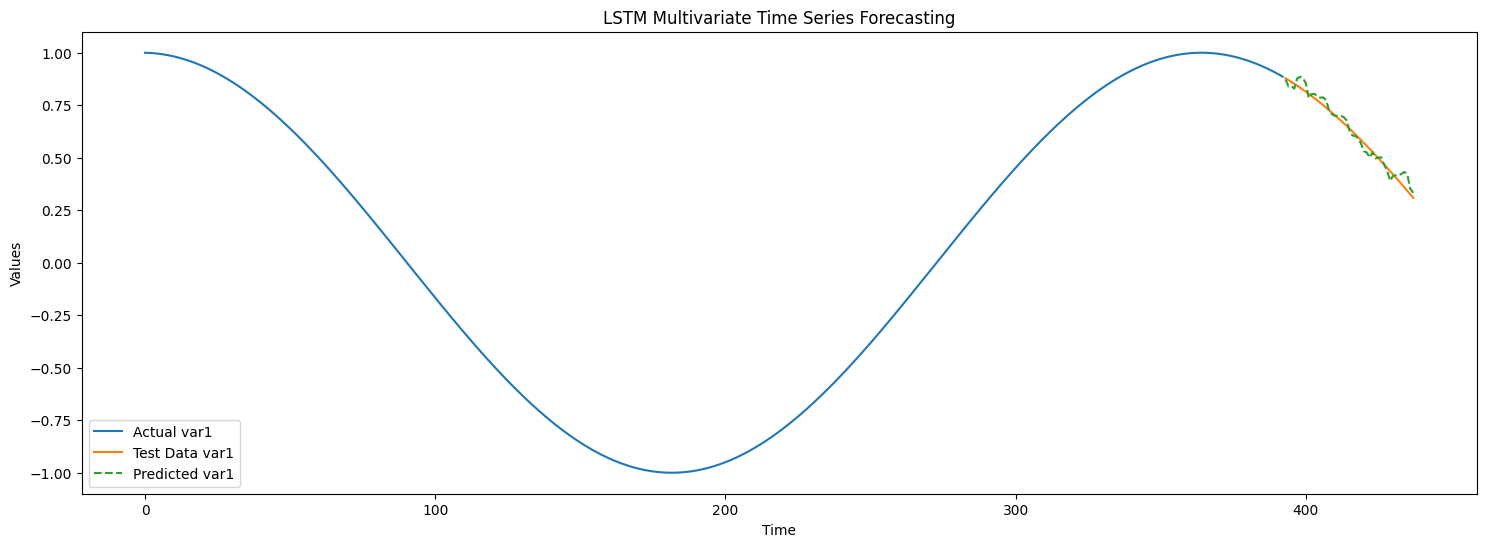

In [51]:
scaled_data_inverse = scaler.inverse_transform(scaled_data)
predicted_values = scaler.inverse_transform(predictions.reshape(-1, y_test.shape[2]))
actual_values = scaler.inverse_transform(y_test.reshape(-1, y_test.shape[2]))

index = 25

# Plot the entire series, training, testing, and predicted data
plt.figure(figsize=(18, 6))
plt.plot(scaled_data_inverse[:scaled_data_inverse.shape[0]-len(y_test)-len(y_val), index], label='Actual var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test)-len(y_val), len(scaled_data_inverse)-len(y_val)), actual_values[:, index], label='Test Data var1')
plt.plot(np.arange(len(scaled_data_inverse) - len(y_test)-len(y_val), len(scaled_data_inverse)-len(y_val)), predicted_values[:, index], label='Predicted var1', linestyle='--')


plt.legend()
plt.title("LSTM Multivariate Time Series Forecasting")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

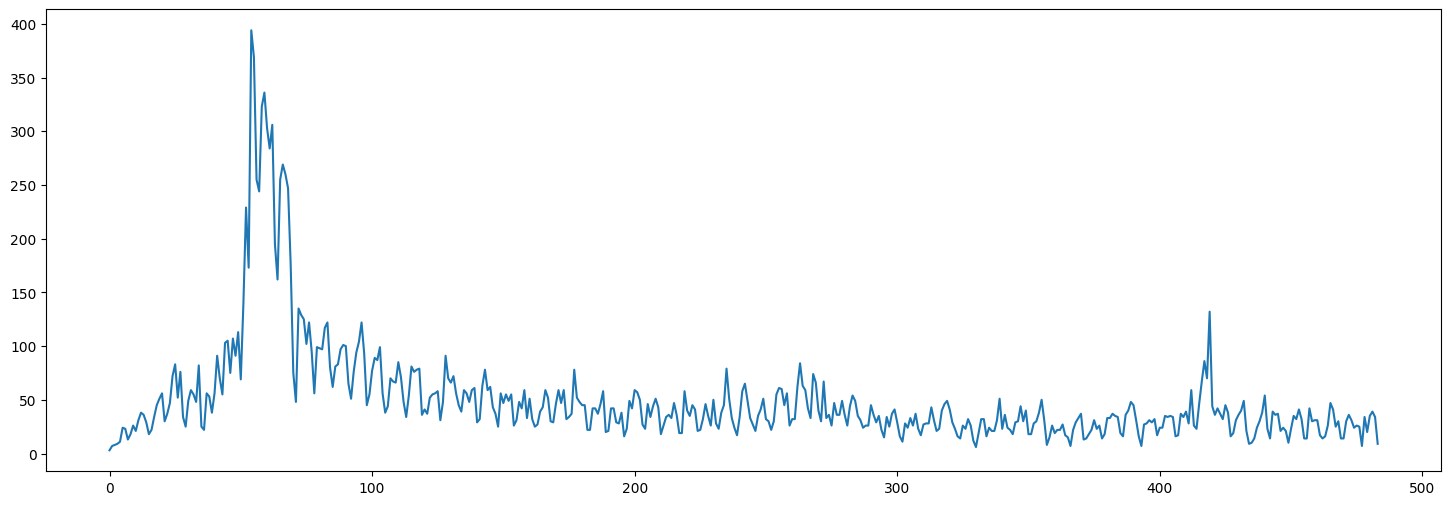

In [40]:
plt.figure(figsize=(18, 6))
plt.plot(scaled_data_inverse[:scaled_data_inverse.shape[0], index], label='Actual var1')
plt.show()

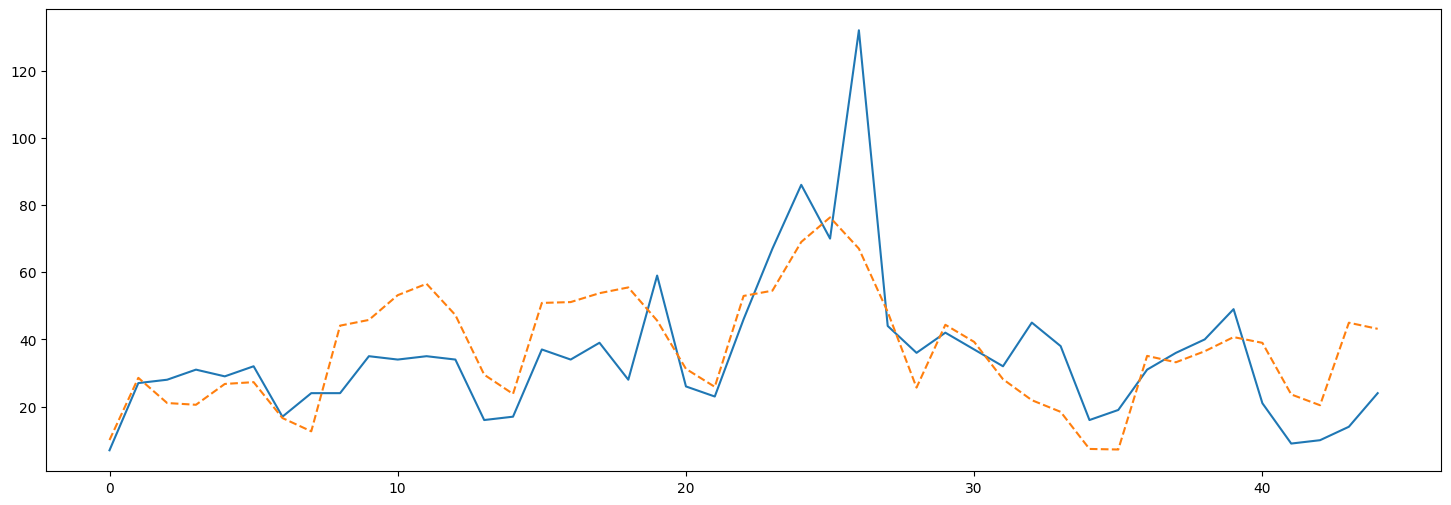

In [49]:
plt.figure(figsize=(18, 6))
plt.plot(actual_values[:, index], label='Test Data var1')
plt.plot(predicted_values[:, index], label='Predicted var1', linestyle='--')
plt.show()

In [32]:
model.save('model.h5')

In [34]:
model = load_model('model.h5')